In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys
from helper_fun_model import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Data source
#### source https://github.com/BlankerL/DXY-COVID-19-Data
- Covid infection data of China only
- using this source as previous source is not updating and had only counts till Feb 11
- git clone https://github.com/BlankerL/DXY-COVID-19-Data.git first

In [23]:
df_blanker = pd.read_csv("../../DXY-COVID-19-Data/csv/DXYArea.csv", parse_dates=True)

In [3]:
df_blanker.shape

(43333, 15)

In [4]:
df_blanker = df_blanker[df_blanker['provinceEnglishName']=='Hubei']

In [5]:
df_blanker.head()

,provinceName,provinceEnglishName,province_zipCode,cityName,cityEnglishName,city_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount,updateTime
204,湖北省,Hubei,420000,武汉,Wuhan,420100.0,58182,0,6693,1696,41152,0,3507,1309,2020-02-17 20:22:59.982
205,湖北省,Hubei,420000,孝感,Xiaogan,420900.0,58182,0,6693,1696,3279,0,449,70,2020-02-17 20:22:59.982
206,湖北省,Hubei,420000,黄冈,Huanggang,421100.0,58182,0,6693,1696,2831,0,839,78,2020-02-17 20:22:59.982
207,湖北省,Hubei,420000,荆州,Jingzhou,421000.0,58182,0,6693,1696,1501,0,305,37,2020-02-17 20:22:59.982
208,湖北省,Hubei,420000,随州,Suizhou,421300.0,58182,0,6693,1696,1267,0,140,24,2020-02-17 20:22:59.982


In [6]:
df_blanker['date'] = df_blanker['updateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())

In [7]:
# Each record is city level counts updated at different timings, therefore we need to first 
# extract each city's max update time
df_daily_max_datetime = df_blanker.groupby(['date','cityName']).agg({'updateTime':'max'}).reset_index()

In [8]:
# then we do a join with the current data on city and on the MAX updatetime
df_daily_max = pd.merge(df_daily_max_datetime, df_blanker, on=['updateTime','date','cityName'], how='inner')

In [9]:
covid_cn = df_daily_max.groupby('date').agg({'city_confirmedCount':'sum'}).reset_index()
covid_cn = covid_cn.iloc[:len(covid_cn)-1 ,:] ## remove today's data as it will not be complete
covid_cn.columns = ['date','infected']

In [10]:
covid_cn['new infected'] = covid_cn['infected'].diff().fillna(1)

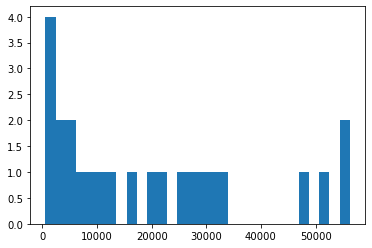

In [11]:
plt.hist(covid_cn['infected'], bins = 30)
plt.show()

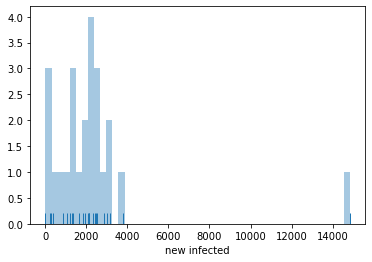

In [12]:
sb.distplot(covid_cn['new infected'], bins=50, kde=False, rug=True);

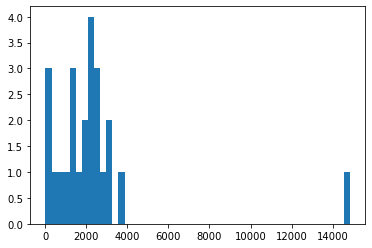

In [13]:
count, gbins, ignored = plt.hist(covid_cn['new infected'], bins=50)

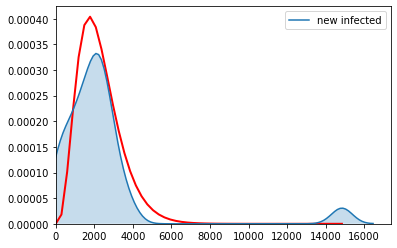

In [14]:
shape, scale = 4.3, 530 # mean=4, std=2*sqrt(2)
import scipy.special as sps

# gcount, gbins, gignored = plt.hist(data, 200, density=True)
# y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
# plt.plot(gbins, y, linewidth=2, color='r')
# plt.show()

# count, gbins, ignored = plt.hist(covid_cn['new infected'], bins=50)
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r')
sb.kdeplot(covid_cn['new infected'], shade=True).set(xlim=(0))

plt.show()

# MCMC

In [15]:
mu = covid_cn['new infected'].mean()
sigma = covid_cn['new infected'].std()

In [16]:
mu, sigma

(2320.875, 2844.88844913882)

In [42]:
# adapted from https://people.duke.edu/~ccc14/sta-663/MCMC.html
from scipy.stats import gamma, norm

def target(theta):
    return gamma.pdf(theta, a=4.3, scale=530)

def transition(theta1, theta2):
    return norm.pdf(abs(theta-theta2))

prior = gamma(a=4.1, scale=530)

theta = mu
niters = 10000
samples = []
samples.append((0,theta))
for i in range(1, niters):
    theta_p = theta + np.random.normal(0, 2.5) # using sigma > 1 because sigma = 1 gives efficiency of 70+%, we can give up some efficiency for better samples
    T_next = target(theta_p)*transition(theta, theta_p) # π(x_cand)q(x(i−1)|x_cand)
    T_prev = target(theta)*transition(theta_p, theta) #   π(x(i−1))q(x_cand|x(i−1))
    
    a = min(1, max(T_next/T_prev,0))
    u = np.random.uniform()
    if u < a:
        theta = theta_p
        samples.append((i,theta))
print("Efficiency = %s" %(len(samples)/niters))

Efficiency = 0.3728


In [43]:
val = np.sum([s[1] for s in samples])
print("Mean of samples: %s" %(val/len(samples)))
print("Stddev of samples: %s" %(np.std([s[1] for s in samples])))

Mean of samples: 2329.3934976652527
Stddev of samples: 16.153078525256042


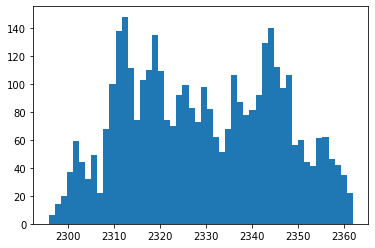

In [44]:
plt.hist([s[1] for s in samples], bins=50)
plt.show()

## References

In [ ]:
import copy

prev_draw = np.random.normal(mu,sigma) #Initialize x(0) ∼ q(x)
sample = []
steps = 1000

for i in range(1, steps):
    if i == 0:
        prev_draw = copy.copy(mu)
    else:
        current = np.random.normal(mu,sigma)
        candidate = transition_model(current, prev_draw) #Propose: x_cand ∼ q(x(i)|x(i−1))
        print("%s, current: %s candidate: %s" %(i,current,candidate))
        T_next = target_model(candidate) # π(x_cand)q(x(i−1)|x_cand)
        T_prev = target_model(current) #   π(x(i−1))q(x_cand|x(i−1))
        a = min(1, max(T_next / T_prev,0)) # Acceptance Probability

        if a > np.random.uniform(0, 1): # u ∼ Uniform (u; 0, 1)
            # Update state
            print("accepted, current: %s candidate: %s" %(current,candidate))
            current = copy.copy(candidate) # Accept the proposal: x(i) ← x_cand
            sample.append(current)
print('Accept ratio:', float(len(sample)) / steps)

In [ ]:
# P(x) : Target distribution
def P(x1, x2, b):
    return np.exp(-0.5 * (x1**2 - 2*b*x1*x2 + x2**2))


# Q(x) : Proposal distribution
def Q(c, mu1, mu2, sigma):
    return (c[0] * np.random.normal(mu1, sigma), c[1] * np.random.normal(mu2, sigma))

def metropolisHastings(mu, sigma):
    current = (10, 10)
    sample = []
    sample.append(current)
    accept_ratio = []

    for i in range(N):
        candidate = Q(current, mu1, mu2, sigma)

        T_prev = P(current[0], current[1], b)
        T_next = P(candidate[0], candidate[1], b)
        a = T_next / T_prev

        if a > 1 or a > np.random.uniform(0, 1):
            # Update state
            current = copy.copy(candidate)
            sample.append(current)
            accept_ratio.append(i)

    print('Accept ratio:', float(len(accept_ratio)) / N)
    return np.array(sample)